In [25]:
import numpy as np
import scipy.stats
import sklearn as skl
import sklearn.datasets as skl_data
from sklearn.experimental import enable_iterative_imputer

import matplotlib as mpl
import matplotlib.pyplot as plt

from cdi.util.analysis.plotting import rasterize_and_save

#mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

## Half-moons

In [2]:
np.random.seed(20210825)
# N = 300
N = 1000
X, Y = skl_data.make_moons(n_samples=N, noise=0.05)

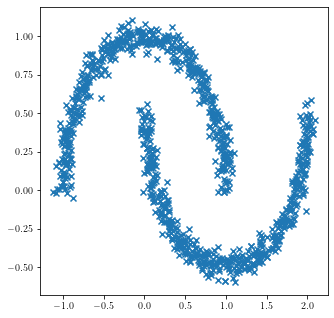

In [3]:
fig = plt.figure(frameon=False, figsize=(4,4))
ax = fig.add_axes([0,0, 1,1])

ax.scatter(X[:, 0], X[:, 1], marker='x')

In [4]:
frac = 0.50
M1 = np.zeros(X.shape[0], dtype=np.bool)
M1[:int(M1.shape[0]*frac)] = 1
np.random.shuffle(M1)

M2 = np.zeros(X.shape[0], dtype=np.bool)
M2[:int(M1.shape[0]*frac)] = 1
np.random.shuffle(M2)

M = M1 | M2

X_incomp = X.copy()
X_incomp[M1, 0] = np.nan
X_incomp[M2, 1] = np.nan

In [5]:
X_incomp[:10]

array([[        nan,         nan],
       [ 0.6706029 ,  0.7951451 ],
       [        nan, -0.19727774],
       [        nan, -0.51113859],
       [        nan,         nan],
       [ 0.2961784 , -0.14430042],
       [        nan,         nan],
       [ 0.24432782, -0.2072733 ],
       [ 0.33577072,         nan],
       [        nan,         nan]])

### KDE

In [6]:
kde_bw = 0.2

In [7]:
np.random.seed(2021082511)
complete_kde = skl.neighbors.KernelDensity(kernel='cosine', bandwidth=kde_bw).fit(X)

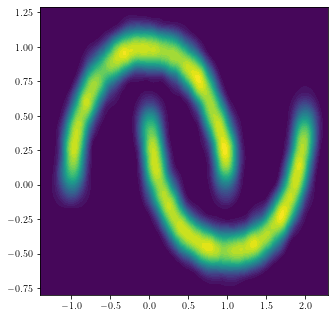

In [8]:
x0, x1 = np.mgrid[-1.4:2.3:.01, -0.8:1.3:.01]
pos = np.vstack([x0.ravel(), x1.ravel()]).T

log_probs = complete_kde.score_samples(pos)
pdf = np.exp(log_probs)

fig = plt.figure(frameon=False, figsize=(4,4))
ax = fig.add_axes([0, 0, 1, 1])
ax.contourf(x0, x1, pdf.reshape(x0.shape), levels=40)

### Complete-case KDE

In [9]:
np.random.seed(2021082511)
complete_case_kde = skl.neighbors.KernelDensity(kernel='cosine', bandwidth=kde_bw).fit(X[~M, ...])

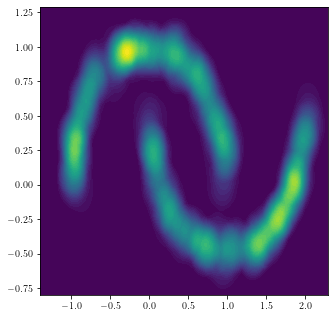

In [10]:
x0, x1 = np.mgrid[-1.4:2.3:.01, -0.8:1.3:.01]
pos = np.vstack([x0.ravel(), x1.ravel()]).T

log_probs = complete_case_kde.score_samples(pos)
pdf = np.exp(log_probs)

fig = plt.figure(frameon=False, figsize=(4,4))
ax = fig.add_axes([0, 0, 1, 1])
ax.contourf(x0, x1, pdf.reshape(x0.shape), levels=40)

### KDE + MCMC

#### Before

In [11]:
X_incomp_temp = X_incomp.copy()
nans = np.hstack([M1[:, None], M2[:, None]])
X_incomp_temp[nans] = 0
X_means = X_incomp_temp.sum(axis=0) / (~nans).sum(axis=0)
X_incomp_temp[M1, 0] = X_means[0]
X_incomp_temp[M2, 1] = X_means[1]
# X_incomp_temp[M1, 0] = np.random.choice(X_incomp_temp[~M1, 0], size=M1.sum(), replace=True)
# X_incomp_temp[M2, 1] = np.random.choice(X_incomp_temp[~M2, 1], size=M2.sum(), replace=True)

np.random.seed(2021082522)
kde = skl.neighbors.KernelDensity(kernel='cosine', bandwidth=kde_bw).fit(X_incomp_temp)

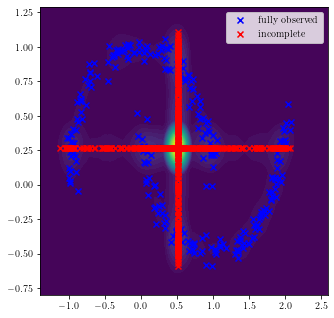

In [12]:
x0, x1 = np.mgrid[-1.4:2.6:.01, -0.8:1.3:.01]
pos = np.vstack([x0.ravel(), x1.ravel()]).T

log_probs = kde.score_samples(pos)
pdf = np.exp(log_probs)

fig = plt.figure(frameon=False, figsize=(4,4))
ax = fig.add_axes([0, 0, 1, 1])
ax.contourf(x0, x1, pdf.reshape(x0.shape), levels=40)

ax.scatter(X_incomp_temp[~M, 0], X_incomp_temp[~M, 1], marker='x', color='b', label='fully observed')
ax.scatter(X_incomp_temp[M, 0], X_incomp_temp[M, 1], marker='x', color='r', label='incomplete')

ax.legend()

#### After MCMC

In [13]:
X_incomp_temp = X_incomp.copy()
nans = np.hstack([M1[:, None], M2[:, None]])
X_incomp_temp[nans] = 0
X_means = X_incomp_temp.sum(axis=0) / (~nans).sum(axis=0)
X_incomp_temp[nans[:, 0], 0] = X_means[0]
X_incomp_temp[nans[:, 1], 1] = X_means[1]
# X_incomp_temp[M1, 0] = np.random.choice(X_incomp_temp[~M1, 0], size=M1.sum(), replace=True)
# X_incomp_temp[M2, 1] = np.random.choice(X_incomp_temp[~M2, 1], size=M2.sum(), replace=True)
maxi = X_incomp_temp.max(axis=0)
mini = X_incomp_temp.min(axis=0)

np.random.seed(2021082533)

p_std = 0.2

num_epochs = 30
num_mcmc_steps = 1000
for i in range(num_epochs):
    kde = skl.neighbors.KernelDensity(kernel='cosine', bandwidth=kde_bw).fit(X_incomp_temp)
    
    # Reset imputations
    X_incomp_temp[nans[:, 0], 0] = X_means[0]
    X_incomp_temp[nans[:, 1], 1] = X_means[1]
#     X_incomp_temp[M1, 0] = np.random.choice(X_incomp_temp[~M1, 0], size=M1.sum(), replace=True)
#     X_incomp_temp[M2, 1] = np.random.choice(X_incomp_temp[~M2, 1], size=M2.sum(), replace=True)
    
    # Perform MCMC
    for j in range(num_mcmc_steps):
        X_proposal = X_incomp_temp.copy()
        
        X_proposal[:, 0] += np.random.randn(X.shape[0])*p_std*nans[:, 0]
        X_proposal[:, 1] += np.random.randn(X.shape[0])*p_std*nans[:, 1]
        
        prev_log_probs = np.clip(kde.score_samples(X_incomp_temp), a_min=-700, a_max=None)
        proposal_log_probs = np.clip(kde.score_samples(X_proposal), a_min=-700, a_max=None)
        
        # The conditional Gaussian proposals cancel so we have just the ratio of the log-probs
        acp = np.exp(proposal_log_probs - prev_log_probs)
        acp_idx = (np.random.rand(X.shape[0]) < acp).astype(np.bool)
        
        X_incomp_temp[acp_idx, :] = X_proposal[acp_idx, :]
        
        X_incomp_temp[:, 0] = np.clip(X_incomp_temp[:, 0], a_min=mini[0], a_max=maxi[0])
        X_incomp_temp[:, 1] = np.clip(X_incomp_temp[:, 1], a_min=mini[1], a_max=maxi[1])

kde = skl.neighbors.KernelDensity(kernel='cosine', bandwidth=kde_bw).fit(X_incomp_temp)

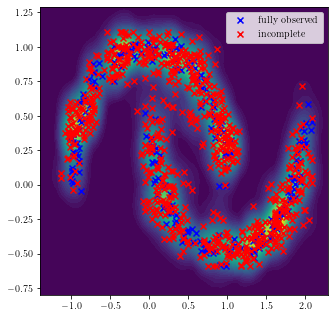

In [14]:
x0, x1 = np.mgrid[-1.4:2.3:.01, -0.8:1.3:.01]
pos = np.vstack([x0.ravel(), x1.ravel()]).T

log_probs = kde.score_samples(pos)
pdf = np.exp(log_probs)

fig = plt.figure(frameon=False, figsize=(4,4))
ax = fig.add_axes([0, 0, 1, 1])
ax.contourf(x0, x1, pdf.reshape(x0.shape), levels=40)

ax.scatter(X_incomp_temp[~M, 0], X_incomp_temp[~M, 1], marker='x', color='b', label='fully observed')
ax.scatter(X_incomp_temp[M, 0], X_incomp_temp[M, 1], marker='x', color='r', label='incomplete')

# ax.set_xlim(-1.5, 2.4)
# ax.set_ylim(-0.8, 1.3)

ax.legend()

### KDE + rejection

In [15]:
X_incomp_rej = X_incomp.copy()
nans = np.hstack([M1[:, None], M2[:, None]])
X_incomp_rej[nans] = 0
X_means = X_incomp_rej.sum(axis=0) / (~nans).sum(axis=0)
X_incomp_rej[M1, 0] = X_means[0]
X_incomp_rej[M2, 1] = X_means[1]
# X_incomp_rej[M1, 0] = np.random.choice(X_incomp_rej[~M1, 0], size=M1.sum(), replace=True)
# X_incomp_rej[M2, 1] = np.random.choice(X_incomp_rej[~M2, 1], size=M2.sum(), replace=True)

np.random.seed(2021082544)
kde_before = skl.neighbors.KernelDensity(kernel='cosine', bandwidth=kde_bw).fit(X_incomp_rej)

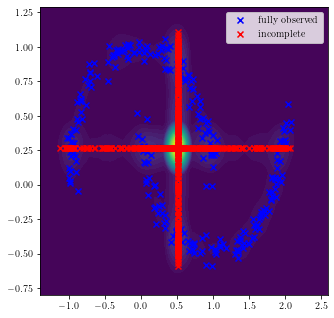

In [16]:
x0, x1 = np.mgrid[-1.4:2.6:.01, -0.8:1.3:.01]
pos = np.vstack([x0.ravel(), x1.ravel()]).T

log_probs = kde_before.score_samples(pos)
pdf = np.exp(log_probs)

fig = plt.figure(frameon=False, figsize=(4,4))
ax = fig.add_axes([0, 0, 1, 1])
ax.contourf(x0, x1, pdf.reshape(x0.shape), levels=40)

ax.scatter(X_incomp_rej[~M, 0], X_incomp_rej[~M, 1], marker='x', color='b', label='fully observed')
ax.scatter(X_incomp_rej[M, 0], X_incomp_rej[M, 1], marker='x', color='r', label='incomplete')

ax.legend()

#### After rejection sampling 

In [17]:
X_incomp_rej = X_incomp.copy()
nans = np.hstack([M1[:, None], M2[:, None]])
X_incomp_rej[nans] = 0
X_means = X_incomp_rej.sum(axis=0) / (~nans).sum(axis=0)
X_incomp_rej[nans[:, 0], 0] = X_means[0]
X_incomp_rej[nans[:, 1], 1] = X_means[1]
# X_incomp_rej[M1, 0] = np.random.choice(X_incomp_rej[~M1, 0], size=M1.sum(), replace=True)
# X_incomp_rej[M2, 1] = np.random.choice(X_incomp_rej[~M2, 1], size=M2.sum(), replace=True)

np.random.seed(2021082555)

incomp = nans.sum(axis=-1) != 0

num_epochs = 100
for i in range(num_epochs):
    kde_rej = skl.neighbors.KernelDensity(kernel='cosine', bandwidth=kde_bw).fit(X_incomp_rej)

    incomp_temp = incomp.copy()
    while incomp_temp.sum() > 0:
#         print(f'epoch: {i}, incomplete {incomp_temp.sum()}')
        X_incomp_rej[incomp_temp, 0] = X_incomp_rej[incomp_temp, 0]*(~nans[incomp_temp, 0]) + (np.random.rand(incomp_temp.sum())*4-1.5)*nans[incomp_temp, 0]
        X_incomp_rej[incomp_temp, 1] = X_incomp_rej[incomp_temp, 1]*(~nans[incomp_temp, 1]) + (np.random.rand(incomp_temp.sum())*2.5-1.)*nans[incomp_temp, 1]
        
        log_probs = np.clip(kde_rej.score_samples(X_incomp_rej), a_min=-1e4, a_max=None)
        probs = np.exp(log_probs)
        
        acp_idx = (np.random.rand(X.shape[0]) < probs).astype(np.bool)
        
        incomp_temp = np.clip((incomp_temp.astype(np.float) - (incomp_temp&acp_idx).astype(np.float)), a_min=0, a_max=1).astype(np.bool)

kde_rej = skl.neighbors.KernelDensity(kernel='cosine', bandwidth=kde_bw).fit(X_incomp_rej)

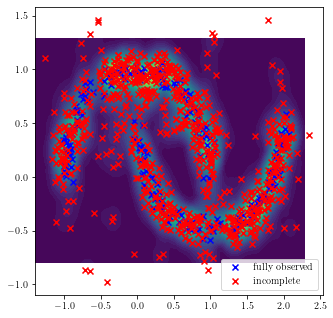

In [18]:
x0, x1 = np.mgrid[-1.4:2.3:.01, -0.8:1.3:.01]
pos = np.vstack([x0.ravel(), x1.ravel()]).T

log_probs = kde_rej.score_samples(pos)
pdf = np.exp(log_probs)

fig = plt.figure(frameon=False, figsize=(4,4))
ax = fig.add_axes([0, 0, 1, 1])
ax.contourf(x0, x1, pdf.reshape(x0.shape), levels=40)

ax.scatter(X_incomp_rej[~M, 0], X_incomp_rej[~M, 1], marker='x', color='b', label='fully observed')
ax.scatter(X_incomp_rej[M, 0], X_incomp_rej[M, 1], marker='x', color='r', label='incomplete')

ax.legend()

### MICE

In [19]:
np.random.seed(2021082566)

imputer = skl.impute.IterativeImputer(
        estimator=skl.linear_model.BayesianRidge(
            n_iter=10000,
            alpha_1=1e-6,
            alpha_2=1e-6,
            lambda_1=1e-6,
            lambda_2=1e-6),
        missing_values=np.nan,
        sample_posterior=True,
        max_iter=100,
        initial_strategy='mean',
        imputation_order='random',
#         random_state=args.model_seed+i*3,
        verbose=True
    )

X_imputed = imputer.fit_transform(X_incomp)

[IterativeImputer] Completing matrix with shape (1000, 2)


In [20]:
mice_kde = skl.neighbors.KernelDensity(kernel='cosine', bandwidth=kde_bw).fit(X_imputed)

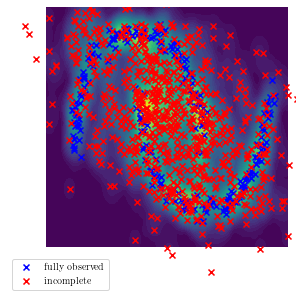

In [21]:
fig = plt.figure(frameon=False, figsize=(4,4))
ax = fig.add_axes([0,0, 1,1])

x0, x1 = np.mgrid[-1.4:2.3:.01, -0.8:1.3:.01]
pos = np.vstack([x0.ravel(), x1.ravel()]).T

log_probs = mice_kde.score_samples(pos)
pdf = np.exp(log_probs)
ax.contourf(x0, x1, pdf.reshape(x0.shape), levels=40)

ax.scatter(X_imputed[~M, 0], X_imputed[~M, 1], marker='x', color='b', label='fully observed')
ax.scatter(X_imputed[M, 0], X_imputed[M, 1], marker='x', color='r', label='incomplete')

ax.set_xlim(-2, 2.4)
ax.set_ylim(-1.2, 1.2)
ax.axis('off')
ax.legend()


### Joint figure "MICE vs KDE"

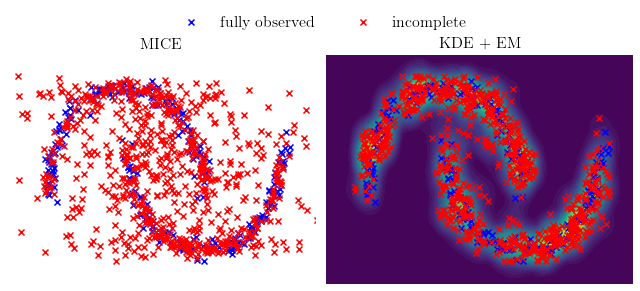

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,figsize=(9, 4))
axes = axes.flatten()

# MICE

axes[0].scatter(X_imputed[~M, 0], X[~M, 1], marker='x', color='b', label='fully observed')
axes[0].scatter(X_imputed[M, 0], X[M, 1], marker='x', color='r', label='incomplete')

axes[0].set_title(label=f'MICE', fontdict={'fontsize': 16})

# KDE

x0, x1 = np.mgrid[-1.5:2.4:.01, -0.8:1.3:.01]
pos = np.vstack([x0.ravel(), x1.ravel()]).T

log_probs = kde.score_samples(pos)
pdf = np.exp(log_probs)

cs = axes[1].contourf(x0, x1, pdf.reshape(x0.shape), levels=40)
# Rasterize contours
for c in cs.collections:
    c.set_rasterized(True)

axes[1].scatter(X_incomp_temp[~M, 0], X_incomp_temp[~M, 1], marker='x', color='b', label='fully observed')
axes[1].scatter(X_incomp_temp[M, 0], X_incomp_temp[M, 1], marker='x', color='r', label='incomplete')

axes[1].set_title(label=f'KDE + EM', fontdict={'fontsize': 16})

for i in range(axes.size):
    axes[i].set_xlim(-1.5, 2.4)
    axes[i].set_ylim(-0.8, 1.3)
    axes[i].axis('off')

fig.tight_layout(rect=(0, 0, 1, 0.93))

# recttuple (left, bottom, right, top)
axes[0].legend(ncol=2, bbox_to_anchor=(0.5, 0.95), 
               bbox_transform=fig.transFigure, 
               loc='center', 
               frameon=False,
               prop={'size': 16})

# plt.savefig('figures/MICE-vs-KDE-EM-imputations.pdf')

### Joint figure "Independent imputations vs Imputations from a density"

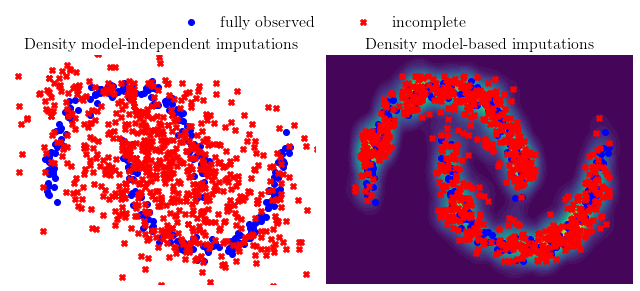

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,figsize=(9, 4))
axes = axes.flatten()

# MICE

axes[0].scatter(X_imputed[~M, 0], X_imputed[~M, 1], marker='o', color='b', label='fully observed')
axes[0].scatter(X_imputed[M, 0], X_imputed[M, 1], marker='X', color='r', label='incomplete')

axes[0].set_title(label=f'Density model-independent imputations', fontdict={'fontsize': 16})

# KDE

x0, x1 = np.mgrid[-1.5:2.4:.01, -0.8:1.3:.01]
pos = np.vstack([x0.ravel(), x1.ravel()]).T

log_probs = kde.score_samples(pos)
pdf = np.exp(log_probs)

cs = axes[1].contourf(x0, x1, pdf.reshape(x0.shape), levels=40)
# Rasterize contours
for c in cs.collections:
    c.set_rasterized(True)

axes[1].scatter(X_incomp_temp[~M, 0], X_incomp_temp[~M, 1], marker='o', color='b', label='fully observed')
axes[1].scatter(X_incomp_temp[M, 0], X_incomp_temp[M, 1], marker='X', color='r', label='imputations')

axes[1].set_title(label=f'Density model-based imputations', fontdict={'fontsize': 16})

for i in range(axes.size):
    axes[i].set_xlim(-1.5, 2.4)
    axes[i].set_ylim(-0.8, 1.3)
    axes[i].axis('off')

fig.tight_layout(rect=(0, 0, 1, 0.93))

# recttuple (left, bottom, right, top)
axes[0].legend(ncol=2, bbox_to_anchor=(0.5, 0.95), 
               bbox_transform=fig.transFigure, 
               loc='center', 
               frameon=False,
               prop={'size': 16})

# plt.savefig('figures/indep-imputations-vs-density-imputations.pdf')

### Joint figure "Imputation-vs-direct-estimation"

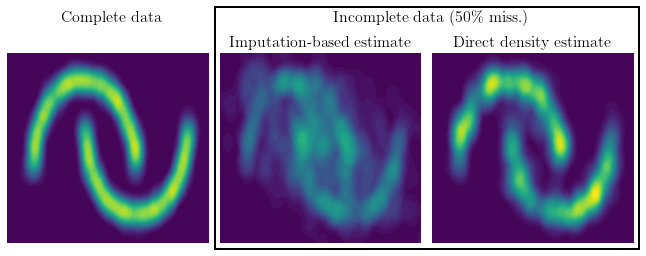

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True,figsize=(9, 3.5))
axes = axes.flatten()

x0, x1 = np.mgrid[-1.5:2.4:.01, -0.8:1.3:.01]
pos = np.vstack([x0.ravel(), x1.ravel()]).T

log_probs = complete_kde.score_samples(pos)
complete_pdf = np.exp(log_probs)

log_probs = mice_kde.score_samples(pos)
mice_pdf = np.exp(log_probs)

# log_probs = kde_rej.score_samples(pos)
log_probs = kde.score_samples(pos)
kde_pdf = np.exp(log_probs)

minn = np.hstack([complete_pdf, mice_pdf, kde_pdf]).min()
maxx = np.hstack([complete_pdf, mice_pdf, kde_pdf]).max()

# Data

axes[0].contourf(x0, x1, complete_pdf.reshape(x0.shape), levels=np.linspace(minn,maxx,40), zorder=-20)
axes[0].set_rasterization_zorder(-10)

# axes[0].set_title(label=f'Density estimate', fontdict={'fontsize': 16})
    

# MICE

axes[1].contourf(x0, x1, mice_pdf.reshape(x0.shape), levels=np.linspace(minn,maxx,40), zorder=-20)
axes[1].set_rasterization_zorder(-10)

# axes[1].scatter(X_imputed[~M, 0], X_imputed[~M, 1], marker='o', color='b', label='fully observed')
# axes[1].scatter(X_imputed[M, 0], X_imputed[M, 1], marker='X', color='r', label='imputations')

axes[1].set_title(label=f'Imputation-based estimate', fontdict={'fontsize': 16})

# KDE

axes[2].contourf(x0, x1, kde_pdf.reshape(x0.shape), levels=np.linspace(minn,maxx,40), zorder=-20)
axes[2].set_rasterization_zorder(-10)

# axes[2].scatter(X_incomp_temp[~M, 0], X_incomp_temp[~M, 1], marker='o', color='b', label='fully observed')
# axes[2].scatter(X_incomp_temp[M, 0], X_incomp_temp[M, 1], marker='X', color='r', label='imputations')

axes[2].set_title(label=f'Direct density estimate', fontdict={'fontsize': 16})

for i in range(axes.size):
    axes[i].set_xlim(-1.5, 2.4)
    axes[i].set_ylim(-0.8, 1.3)
    axes[i].axis('off')

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.91))

pos0 = axes[0].get_position()
pos1 = axes[1].get_position()
pos2 = axes[2].get_position()

rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0.337, 0.02), 0.655, 0.96, 
    fill=False, color="k", lw=2, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.append(rect)

# txt1 = plt.Text("asasdfgdg!!!d", (0.1, 0.5), color="k", 
#                 zorder=1000, transform=fig.transFigure, figure=fig)

# fig.patches.append(rect)

fig.text(0.1, 0.92, 
         'Complete data', color='k', visible=True, size=16)

fig.text(0.52, 0.92, 
         f'Incomplete data ({frac*100:.0f}\% miss.)', color='k', visible=True, size=16)

# recttuple (left, bottom, right, top)
# axes[1].legend(ncol=2, bbox_to_anchor=(0.5, 0.95), 
#                bbox_transform=fig.transFigure, 
#                loc='center', 
#                frameon=False,
#                prop={'size': 16})

# plt.savefig('figures/complete-vs-imputation-based-vs-direct-density-estimates.pdf', dpi=500)

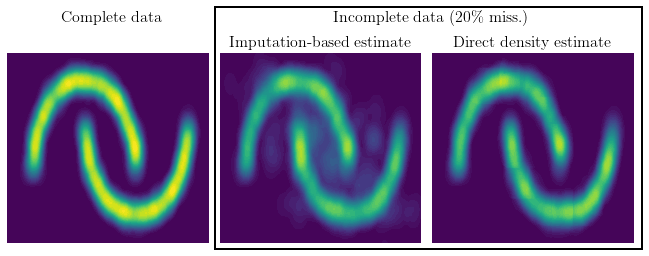

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True,figsize=(9, 3.5))
axes = axes.flatten()

x0, x1 = np.mgrid[-1.5:2.4:.01, -0.8:1.3:.01]
pos = np.vstack([x0.ravel(), x1.ravel()]).T

log_probs = complete_kde.score_samples(pos)
complete_pdf = np.exp(log_probs)

log_probs = mice_kde.score_samples(pos)
mice_pdf = np.exp(log_probs)

# log_probs = kde_rej.score_samples(pos)
log_probs = kde.score_samples(pos)
kde_pdf = np.exp(log_probs)

minn = np.hstack([complete_pdf, mice_pdf, kde_pdf]).min()
maxx = np.hstack([complete_pdf, mice_pdf, kde_pdf]).max()

# Data

cs = axes[0].contourf(x0, x1, complete_pdf.reshape(x0.shape), levels=np.linspace(minn,maxx,40))
# Rasterize contours
for c in cs.collections:
    c.set_rasterized(True)

# axes[0].set_title(label=f'Density estimate', fontdict={'fontsize': 16})
    

# MICE

cs = axes[1].contourf(x0, x1, mice_pdf.reshape(x0.shape), levels=np.linspace(minn,maxx,40))
# Rasterize contours
for c in cs.collections:
    c.set_rasterized(True)

# axes[1].scatter(X_imputed[~M, 0], X_imputed[~M, 1], marker='o', color='b', label='fully observed')
# axes[1].scatter(X_imputed[M, 0], X_imputed[M, 1], marker='X', color='r', label='imputations')

axes[1].set_title(label=f'Imputation-based estimate', fontdict={'fontsize': 16})

# KDE

cs = axes[2].contourf(x0, x1, kde_pdf.reshape(x0.shape), levels=np.linspace(minn,maxx,40))
# Rasterize contours
for c in cs.collections:
    c.set_rasterized(True)

# axes[2].scatter(X_incomp_temp[~M, 0], X_incomp_temp[~M, 1], marker='o', color='b', label='fully observed')
# axes[2].scatter(X_incomp_temp[M, 0], X_incomp_temp[M, 1], marker='X', color='r', label='imputations')

axes[2].set_title(label=f'Direct density estimate', fontdict={'fontsize': 16})

for i in range(axes.size):
    axes[i].set_xlim(-1.5, 2.4)
    axes[i].set_ylim(-0.8, 1.3)
    axes[i].axis('off')

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.91))

pos0 = axes[0].get_position()
pos1 = axes[1].get_position()
pos2 = axes[2].get_position()

rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0.337, 0.02), 0.66, 0.96, 
    fill=False, color="k", lw=2, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.append(rect)

# txt1 = plt.Text("asasdfgdg!!!d", (0.1, 0.5), color="k", 
#                 zorder=1000, transform=fig.transFigure, figure=fig)

# fig.patches.append(rect)

fig.text(0.1, 0.92, 
         'Complete data', color='k', visible=True, size=16)

fig.text(0.52, 0.92, 
         f'Incomplete data ({frac*100:.0f}\% miss.)', color='k', visible=True, size=16)

# recttuple (left, bottom, right, top)
# axes[1].legend(ncol=2, bbox_to_anchor=(0.5, 0.95), 
#                bbox_transform=fig.transFigure, 
#                loc='center', 
#                frameon=False,
#                prop={'size': 16})

# plt.savefig('figures/complete-vs-imputation-based-vs-direct-density-estimates.pdf')